In [1]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
# import pandas.stats.moments as st
import statsmodels.api as sm # import statsmodels 
from pandas import ExcelWriter
import matplotlib.pyplot as pyplot
import scipy.stats as st
import os
import quandl as qd
from collections import defaultdict
import seaborn as sns
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return


C:\Users\Fang\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
# Importing data from Quandl

btc = qd.get("BITFINEX/BTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
btc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

eth = qd.get("BITFINEX/ETHUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
eth.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

ltc = qd.get("BITFINEX/LTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
ltc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

neo = qd.get("BITFINEX/NEOUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
neo.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

etc = qd.get("BITFINEX/ETCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
etc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

rrt = qd.get("BITFINEX/RRTUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
rrt.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

xmr = qd.get("BITFINEX/XMRUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
xmr.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']



In [4]:
# List of Crypto Data
# BTC ETH XRP BCH LTC DASH NEM Monero IOTA ETC OMG NEO BCC LSK
# Data has Open, High, Low, Close, Volume, Marketcap

def crypto_ma_opt(crypto, fast = 1, slow = 10, show_values = False):
    
    df = crypto.copy()
    
    df['fast'] = df[['Close']].rolling(fast).mean().shift(1)
    df['slow'] = df['Close'].rolling(slow).mean().shift(1)
    
    df['return'] = df['Close']/df['Close'].shift(1) - 1
    df['signal'] = df['fast'] >= df['slow']
    
    df['signal_return'] = df['signal']*df['return'].shift(-1)
    df['cumulative_return'] = ((df['return']+1).cumprod() - 1)
    df['signal_cumulative'] = ((df['signal_return']+1).cumprod() - 1)
    
    df = df.dropna()
    
    cumulative_return = df['cumulative_return'][-1]
    signal_cumulative = df['signal_cumulative'][-1]
    
    df_graph = df[['cumulative_return','signal_cumulative']]
    df_graph.columns = ['Cumulative Return', 'Algo Cumulative Return']
    
    if show_values:
        print(str(round(cumulative_return,2)))
        print(str(round(signal_cumulative,2)))
        df_graph.plot(figsize = (20,10))
        pyplot.title('Cumulative Returns', fontsize = 30)
        pyplot.ylabel('Returns', fontsize = 20)
        pyplot.xlabel('Date', fontsize = 20)
        pyplot.tick_params(labelsize=16)
        pyplot.legend(prop={'size': 16})
    
    return signal_cumulative

def heat_map(df):
    """
    This creates our heatmap using our sharpe ratio dataframe
    """
    fig = pyplot.figure(figsize=(10, 20))
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values,cmap = pyplot.get_cmap('RdYlGn'), interpolation = 'nearest')
    ax.set_xlabel(df.columns.name, fontsize = 16)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns), fontsize = 16)
    ax.set_ylabel(df.index.name, fontsize = 16)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index), fontsize = 16)
    ax.set_title("SMA Returns", fontsize = 20)
    pyplot.colorbar(axim)
    pyplot.tick_params(labelsize=16)
    
def sma_opt(fast_upper, slow_upper, crypto, show_heat = True, show_returns = False, show_backtest = False):
    
    # This will create a list with 9 entries
    short_mavg_days = [days for days in np.arange(5, fast_upper, 5)]
    # This will create a list with 43 entries
    long_mavg_days = [days for days in np.arange(10, slow_upper, 5)]

    #: Create a dictionary to hold all the results of our algorithm run
    all_returns = defaultdict(dict)

    # Count the number of backtests run
    backtest_count = 0

    # This will loop and run backtests
    # Each backtest takes about 3 seconds
    for short_mavg_day in short_mavg_days:
        for long_mavg_day in long_mavg_days:
            # Only consider cases where the short is less than long.. but why this not working?
            if short_mavg_day < long_mavg_day:
                
                curr_return = crypto_ma_opt(crypto, short_mavg_day, long_mavg_day)
                
                # Keep track of how many backtests were run
                if show_backtest:
                    backtest_count += 1
                    print("Backtest " + str(backtest_count) + " completed...")
            
                #: Add the result to our dict
                all_returns[short_mavg_day][long_mavg_day] = curr_return

    if show_backtest:
        print(" ")
        print("All backtest simulations completed!")
        print(" ")

    all_returns = pd.DataFrame(all_returns)
    all_returns.index.name = "Long Moving Average Days"
    all_returns.columns.name = "Short Moving Average Days"
    
    if show_heat:
        heat_map(all_returns)
    
    short_opt = all_returns.max().idxmax()
    long_opt = all_returns.max(axis = 1).idxmax()
    ret_opt = max(all_returns.max())
    print("Optimal MA cross is: " + str(short_opt) + "-" + str(long_opt))
    print("With optimal return: " + str(round(ret_opt*100,2)) + "%")
    
    if show_returns:
        crypto_ma_opt(crypto, short_opt, long_opt, show_values = True)
    
    return all_returns

def crypto_ma_signal(crypto, fast = 1, slow = 10):
    
    df = crypto.copy()
    
    df['fast'] = df[['Close']].rolling(fast).mean().shift(1)
    df['slow'] = df['Close'].rolling(slow).mean().shift(1)
    
    df['return'] = df['Close']/df['Close'].shift(1) - 1
    df['signal'] = df['fast'] >= df['slow']
    
    return df[['Close','fast','slow','signal']].tail(5)

Optimal MA cross is: 10-20
With optimal return: 1107.47%
6.7
11.07
             Close     fast      slow  signal
Date                                         
2017-09-23  3751.8  3752.46  4065.800   False
2017-09-24  3681.0  3734.13  4025.240   False
2017-09-25  3924.5  3772.57  3996.785   False
2017-09-26  3886.0  3790.88  3970.610   False
2017-09-27  4196.1  3808.42  3934.190   False


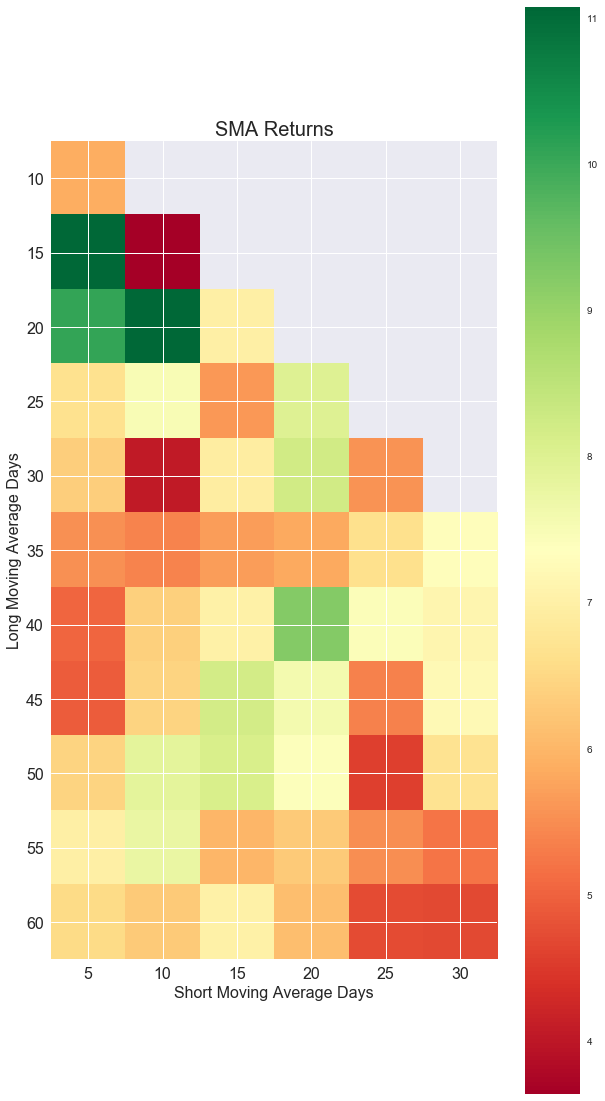

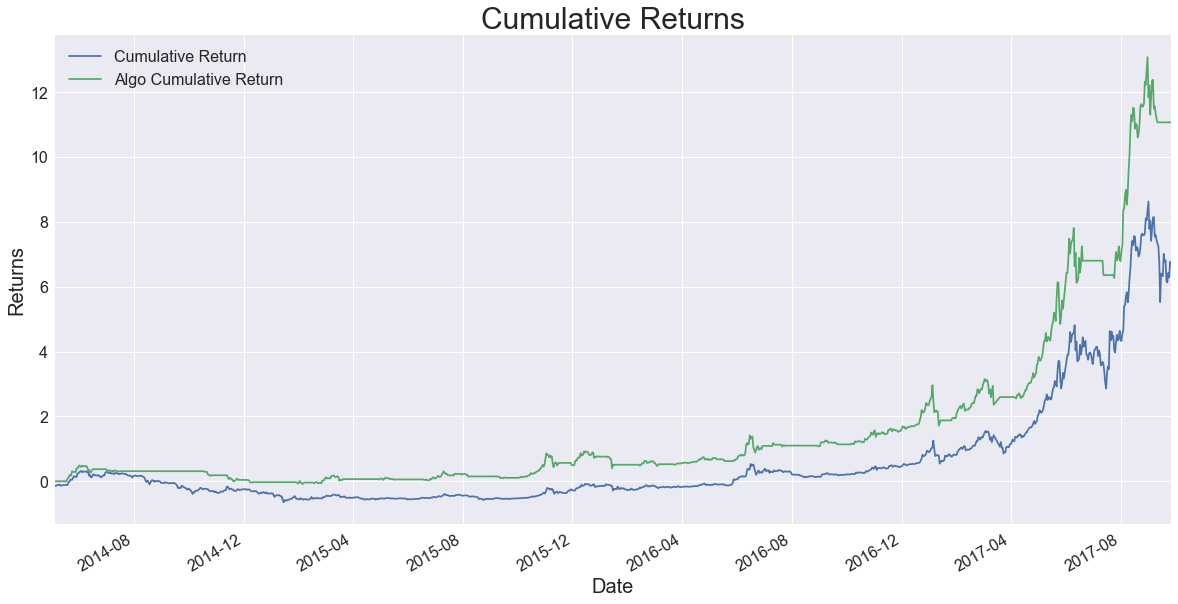

In [11]:
# Crypto latest MAs
# BTC 10-20
# ETH 5-30
# LTC 15-35
# NEO 5-20
# ETC 5-25
# RRT 5-10
# XMR 15-20
btc_opt = sma_opt(35, 65, btc, show_heat = True, show_returns = True, show_backtest = False)
print(crypto_ma_signal(btc, 10, 20))

Optimal MA cross is: 5-30
With optimal return: 4564.64%
21.32
45.65
             Close     fast        slow  signal
Date                                           
2017-09-23  282.15  276.892  311.917333   False
2017-09-24  286.94  274.650  310.486000   False
2017-09-25  294.62  275.456  309.061000   False
2017-09-26  288.54  276.738  307.814667   False
2017-09-27  309.68  282.676  306.066667   False


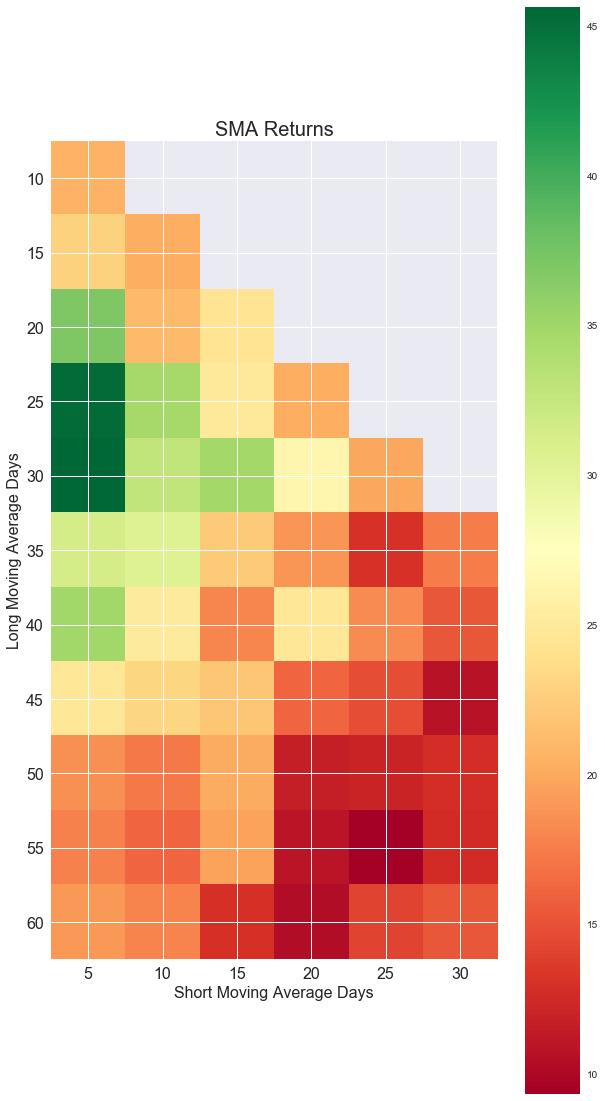

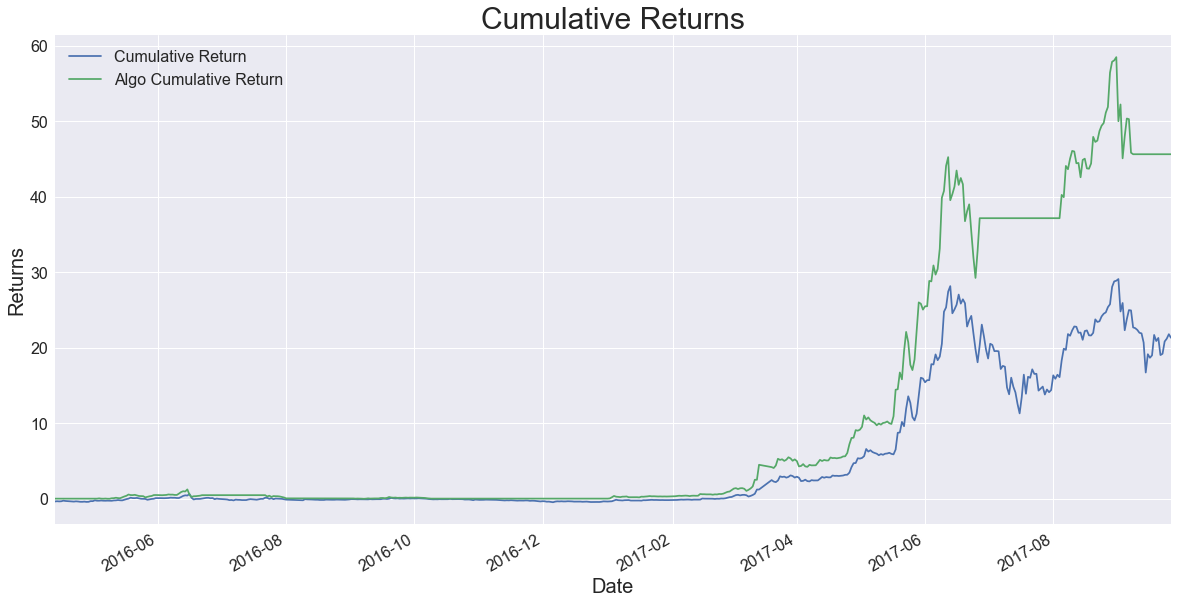

In [10]:
# Crypto latest MAs
# BTC 10-20
# ETH 5-30
# LTC 15-35
# NEO 5-20
# ETC 5-25
# RRT 5-10
# XMR 15-20
eth_opt = sma_opt(35, 65, eth, show_heat = True, show_returns = True, show_backtest = False)
print(crypto_ma_signal(eth, 5, 30))

Optimal MA cross is: 15-35
With optimal return: 2813.39%
2.99
28.13
             Close       fast       slow  signal
Date                                            
2017-09-23  48.843  57.995067  60.743600   False
2017-09-24  47.670  56.391267  60.851000   False
2017-09-25  52.316  54.762600  60.879686   False
2017-09-26  52.458  53.720333  60.985800   False
2017-09-27  56.510  52.680200  61.159029   False


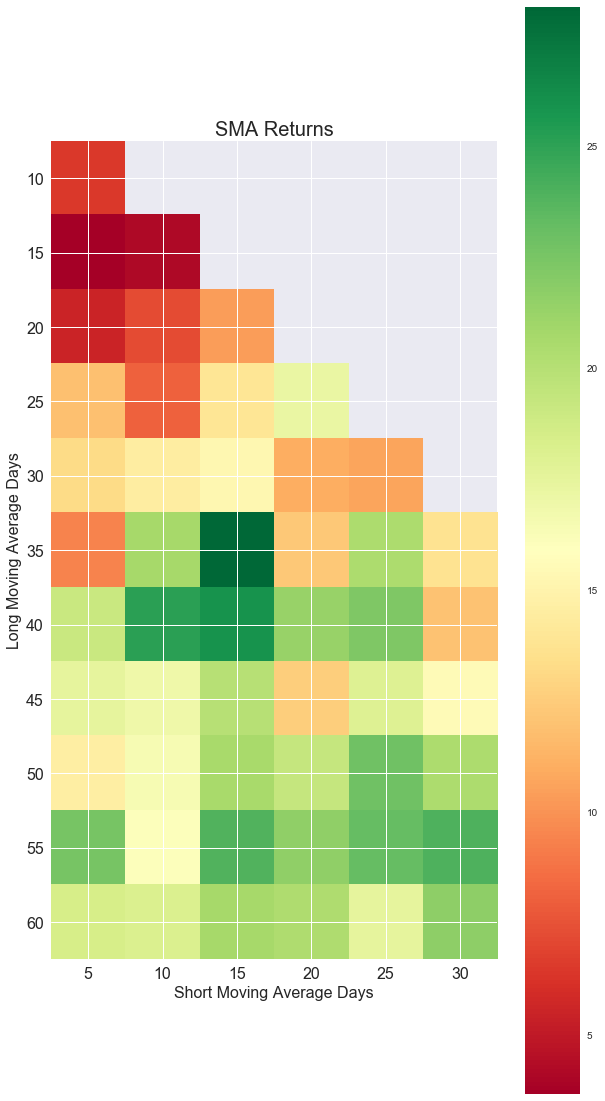

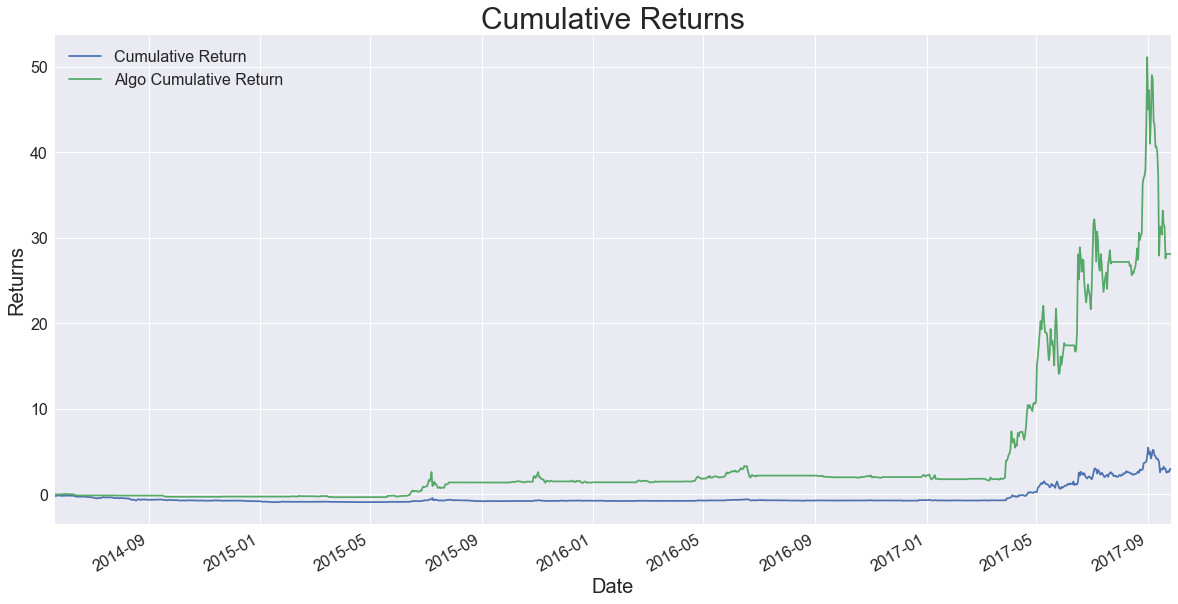

In [14]:
# Crypto latest MAs
# BTC 10-20
# ETH 5-30
# LTC 15-35
# NEO 5-20
# ETC 5-25
# RRT 5-10
# XMR 15-20
ltc_opt = sma_opt(35, 65, ltc, show_heat = True, show_returns = True, show_backtest = False)
print(crypto_ma_signal(ltc, 15, 35))

Optimal MA cross is: 5-10
With optimal return: 39.12%
-0.13
0.39
             Close     fast     slow  signal
Date                                        
2017-09-23  20.100  19.5054  19.4776    True
2017-09-24  19.889  19.3016  19.4369   False
2017-09-25  26.400  19.2692  19.7514   False
2017-09-26  26.430  20.5238  20.5054    True
2017-09-27  32.132  22.3336  21.0544    True


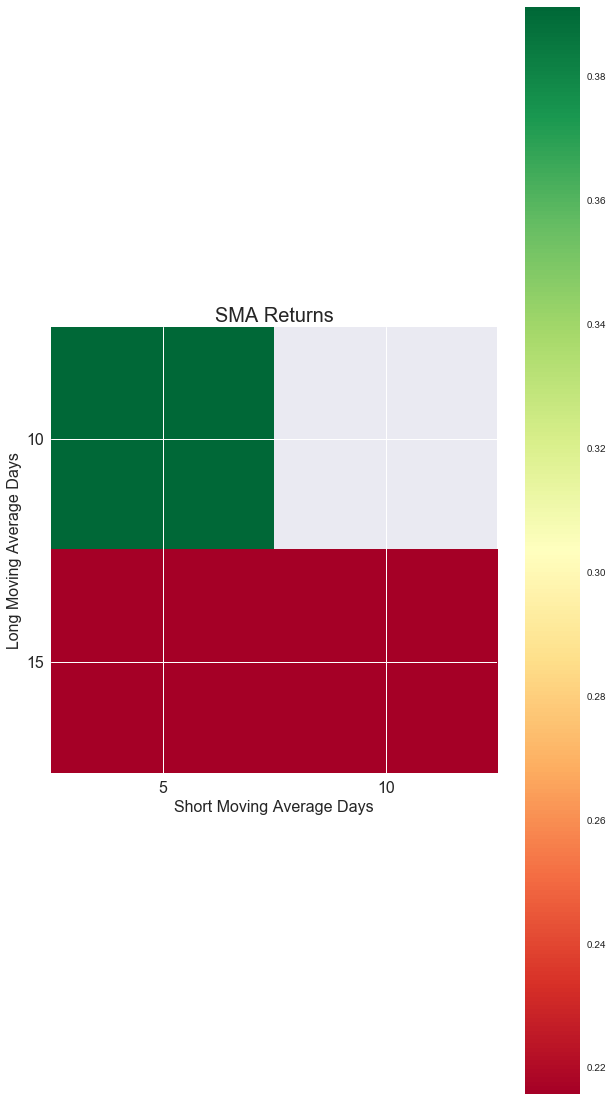

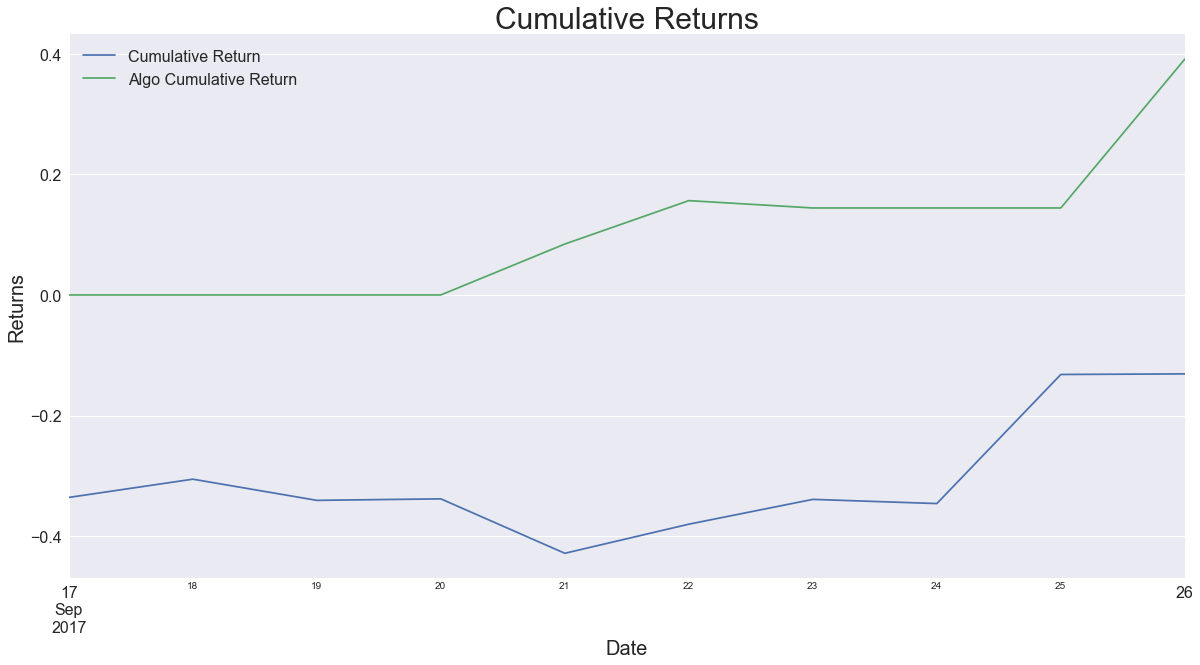

In [21]:
# Crypto latest MAs
# BTC 10-20
# ETH 5-30
# LTC 15-35
# NEO 5-20
# ETC 5-25
# RRT 5-10
# XMR 15-20
neo_opt = sma_opt(20, 20, neo, show_heat = True, show_returns = True, show_backtest = False)
print(crypto_ma_signal(neo, 5, 10))

Optimal MA cross is: 5-25
With optimal return: 1161.25%
6.67
11.61
             Close     fast      slow  signal
Date                                         
2017-09-23  10.469  11.0448  14.93428   False
2017-09-24  10.528  10.7330  14.71744   False
2017-09-25  11.000  10.5346  14.50856   False
2017-09-26  11.541  10.4546  14.28056   False
2017-09-27  12.992  10.7448  13.86552   False


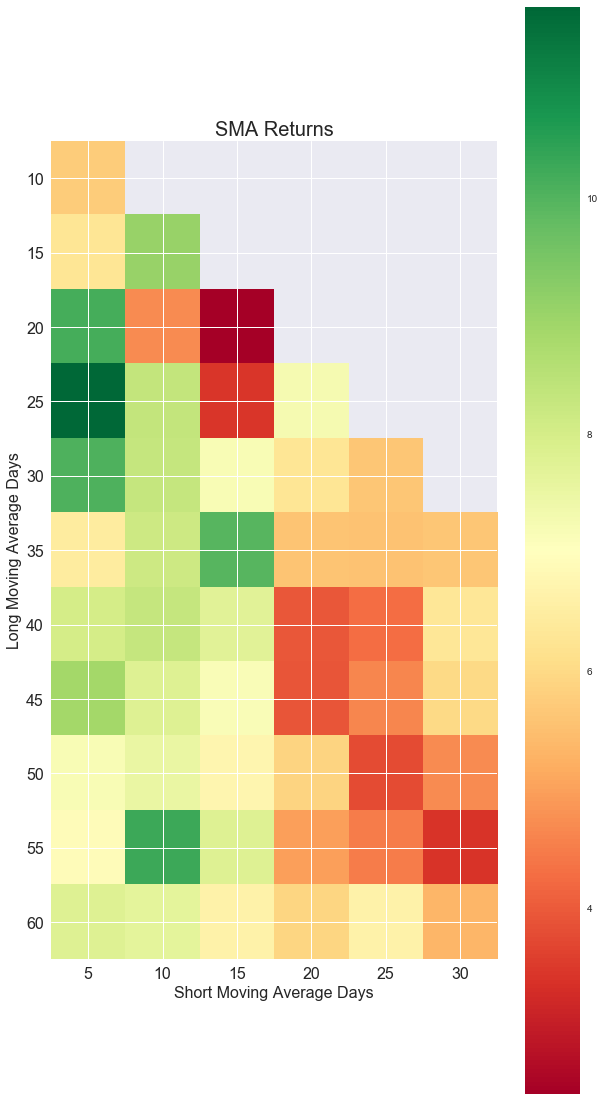

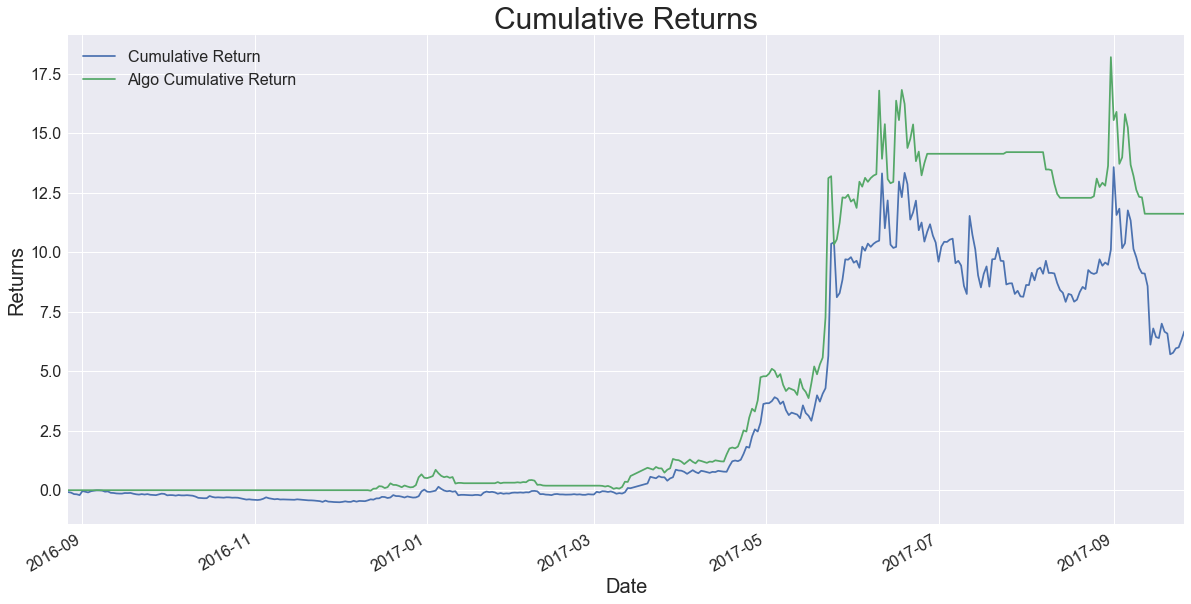

In [25]:
# Crypto latest MAs
# BTC 10-20
# ETH 5-30
# LTC 15-35
# NEO 5-20
# ETC 5-25
# RRT 5-10
# XMR 15-20
etc_opt = sma_opt(35, 65, etc, show_heat = True, show_returns = True, show_backtest = False)
print(crypto_ma_signal(etc, 5, 25))

Optimal MA cross is: 5-10
With optimal return: 472.91%
0.27
4.73
              Close      fast      slow  signal
Date                                           
2017-09-23  0.15263  0.158880  0.149395    True
2017-09-24  0.14215  0.153810  0.148577    True
2017-09-25  0.14510  0.150366  0.149281    True
2017-09-26  0.15088  0.147374  0.149019   False
2017-09-27  0.15040  0.148250  0.151266   False


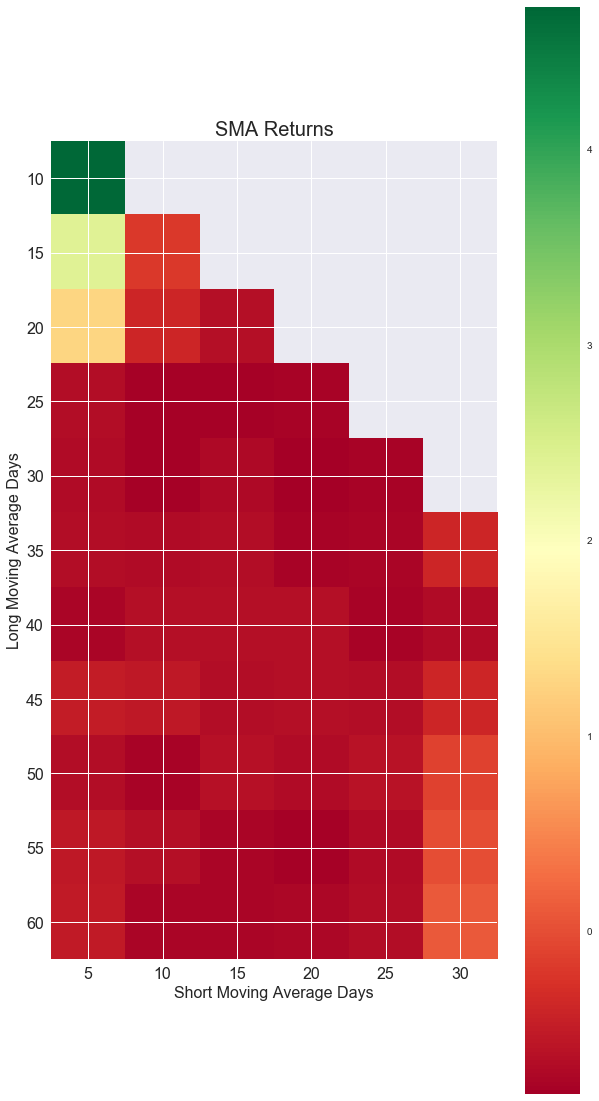

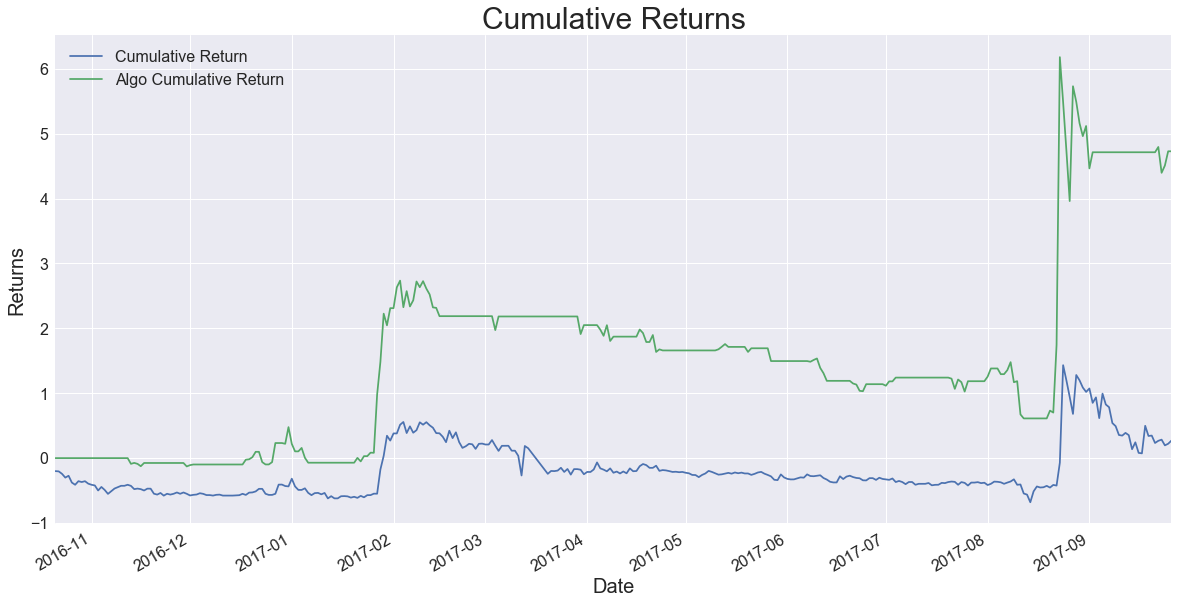

In [27]:
# Crypto latest MAs
# BTC 10-20
# ETH 5-30
# LTC 15-35
# NEO 5-20
# ETC 5-25
# RRT 5-10
# XMR 15-20
rrt_opt = sma_opt(35, 65, rrt, show_heat = True, show_returns = True, show_backtest = False)
print(crypto_ma_signal(rrt, 5, 10))

Optimal MA cross is: 15-20
With optimal return: 1022.85%
9.36
10.23
              Close        fast       slow  signal
Date                                              
2017-09-23   91.322  102.360067  106.72155   False
2017-09-24   89.657  100.635533  105.04765   False
2017-09-25   94.000   98.879333  104.15500   False
2017-09-26   93.531   97.546000  102.87950   False
2017-09-27  101.720   96.281400  101.34505   False


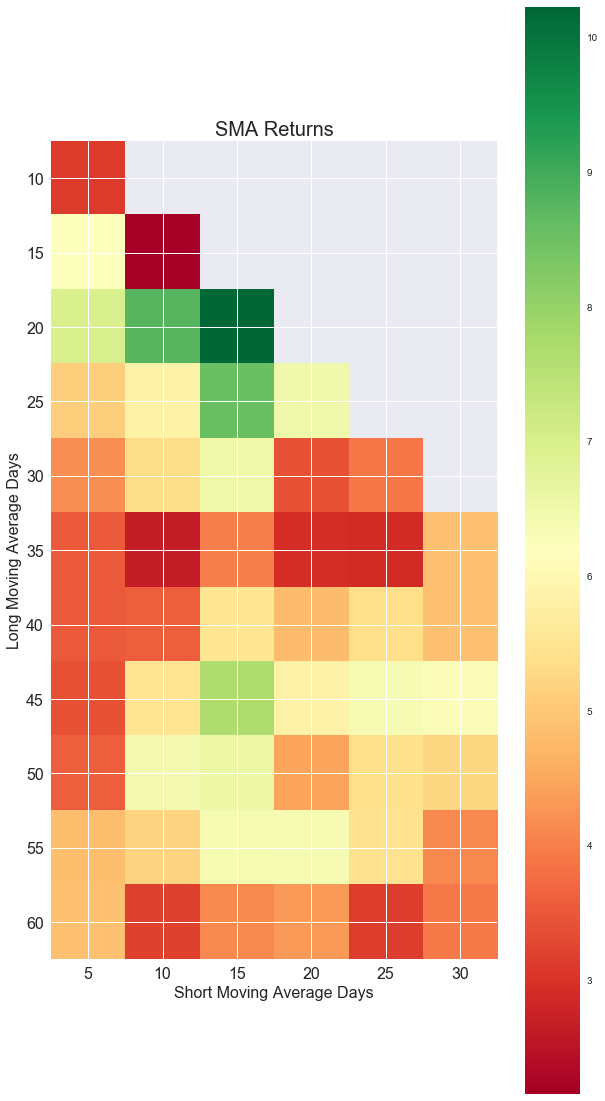

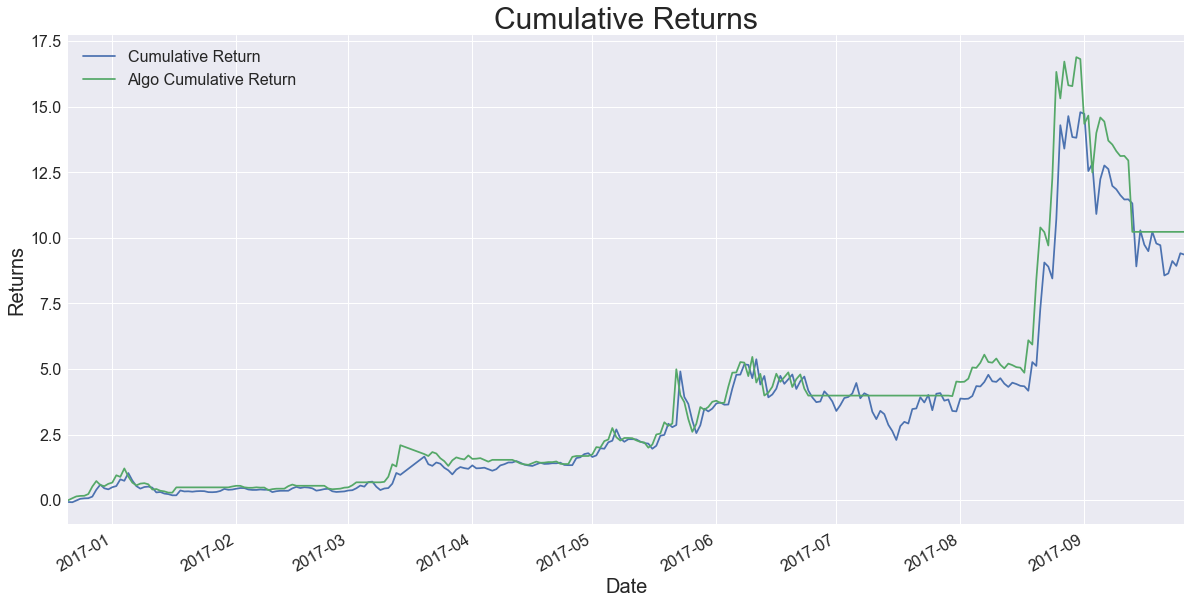

In [29]:
# Crypto latest MAs
# BTC 10-20
# ETH 5-30
# LTC 15-35
# NEO 5-20
# ETC 5-25
# RRT 5-10
# XMR 15-20
xmr_opt = sma_opt(35, 65, xmr, show_heat = True, show_returns = True, show_backtest = False)
print(crypto_ma_signal(xmr, 15, 20))

